Heart Failure Prediction
========================

This notebook implements a complete end‐to‐end workflow for predicting 
the presence of heart disease from clinical and exercise test features.

Contents
--------
1.  Mount and load the dataset (heart_failure.csv)
2.  Exploratory Data Analysis (EDA)
    - Summary statistics, missing values, class balance
    - Univariate and bivariate plots
3.  Data preprocessing
    - Impute missing values (mode, median, conditional)
    - Nominal one‐hot encoding
    - Ordinal encoding for naturally ordered categories
    - Feature scaling (StandardScaler)
4.  Feature engineering / selection
    - Create flags for missingness
    - Correlation analysis
5.  Model training and hyperparameter tuning
    - Logistic Regression (GridSearchCV)
    - Random Forest (GridSearchCV)
    - CatBoost (GridSearchCV)
6.  Model evaluation
    - Accuracy, precision/recall/F1, confusion matrices
    - ROC curves and AUC
    - Feature importances
7.  Final comparison and conclusions

Usage
-----
- Run each cell in order in a Colab or Jupyter environment.
- Adjust file paths if necessary.
- Review and modify hyperparameter grids to suit your needs.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import os

# !pip install missingno
import missingno as msno
from datetime import date
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler

In [ ]:
# some adjustments
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)

In [ ]:
import os
os.getcwd()
df_ = pd.read_csv("/content/drive/MyDrive/ai for bio/Assesment1/heart_failure.csv")
df = df_.copy()

df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.000,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.000,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.000,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.500,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.000,Up,0


In [ ]:
# auxiliary functions
def check_df(dataframe):

    # prints summary of a given dataframe.

    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(3))
    print("##################### Tail #####################")
    print(dataframe.tail(3))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")

    numeric_df = df.select_dtypes(include=np.number)
    print(numeric_df.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)




def grab_col_names(dataframe, cat_th=10, car_th=20):
    """
    This function categorises the colums of the DataFrame into categorical, numerical, and high-cardinality categorical.

    cat_cols: Categorical columns – These are typically columns with a limited number of unique values that represent distinct categories or groups.
    num_cols: Numerical columns – These columns contain numbers that can be used for mathematical calculations and statistical analysis.
    cat_but_car: High cardinality categorical columns – These are categorical columns with a very large number of unique values, making them potentially less useful for some analysis techniques.
    High cardinality means there are many unique values compared to the number of rows.
    ------
        dataframe: dataframe

        cat_th: int, optional

        car_th: int, optinal


    Returns
    ------
        cat_cols: list
                Categorical features
        num_cols: list
                Numerical features
        cat_but_car: list
               Categorical view cardinal variable list

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))

    """
# High cardinality means there are many unique values compared to the number of rows.

    # cat_cols, cat_but_car
    # cat_th(categorical threshold) is the threshold value that is used to determine whether a coloumn is categorical or no.
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    #  List of objects that are cetegorical.

    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    # List of numberical columns that have unique values less than the cat_th(treated as categorical)

    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Total number of observations: {dataframe.shape[0]}")
    print(f"Total Variables: {dataframe.shape[1]}")
    print(f'No. of categorial columns: {len(cat_cols)}')
    print(f'No. of numerical columns: {len(num_cols)}')
    print(f'No. of high-cardinality categorial columns: {len(cat_but_car)}')
    print(f'No. of num. features with low no. of unique values treated as categorial: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car, num_but_cat


def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)              # Calculates percentage of missing values for columns that have any empty data points.
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")
    if na_name:
        return na_columns

def missing_vs_target(dataframe, target, na_columns):
    temp_df = dataframe.copy()

    for col in na_columns:
        temp_df[col + '_NA_FLAG'] = np.where(temp_df[col].isnull(), 1, 0)

    na_flags = temp_df.loc[:, temp_df.columns.str.contains("_NA_")].columns

    for col in na_flags:
        print(pd.DataFrame({"TARGET_MEAN": temp_df.groupby(col)[target].mean(),
                            "Count": temp_df.groupby(col)[target].count()}), end="\n\n\n")



# Feature Analysis

In [ ]:
# check_df(df).
df.columns = [col.upper() for col in df.columns]
print(f"Columns: {df.columns.tolist()}")

Columns: ['AGE', 'SEX', 'CHESTPAINTYPE', 'RESTINGBP', 'CHOLESTEROL', 'FASTINGBS', 'RESTINGECG', 'MAXHR', 'EXERCISEANGINA', 'OLDPEAK', 'ST_SLOPE', 'HEARTDISEASE']


In [ ]:
cat_cols, num_cols, cat_but_car,num_but_cat  = grab_col_names(df)

print()
print()

print(f"Categorial columns: {cat_cols}")
print(f"Numerical columns: {num_cols}")
print(f"High-cardinality categorial columns: {cat_but_car}")
print(f"Numberical columns with unique values below the categorical threshold treated as categorical: {num_but_cat} ")

Total number of observations: 918
Total Variables: 12
No. of categorial columns: 7
No. of numerical columns: 5
No. of high-cardinality categorial columns: 0
No. of num. features with low no. of unique values treated as categorial: 2


Categorial columns: ['SEX', 'CHESTPAINTYPE', 'RESTINGECG', 'EXERCISEANGINA', 'ST_SLOPE', 'FASTINGBS', 'HEARTDISEASE']
Numerical columns: ['AGE', 'RESTINGBP', 'CHOLESTEROL', 'MAXHR', 'OLDPEAK']
High-cardinality categorial columns: []
Numberical columns with unique values below the categorical threshold treated as categorical: ['FASTINGBS', 'HEARTDISEASE'] 


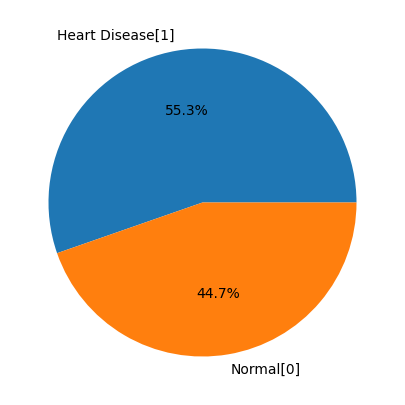

In [ ]:
# Normal and Heart Disease with target column
plt.figure(figsize=(10,5))
plt.pie(df['HEARTDISEASE'].value_counts(), labels=['Heart Disease[1]', 'Normal[0]'], autopct='%1.1f%%')
plt.show()

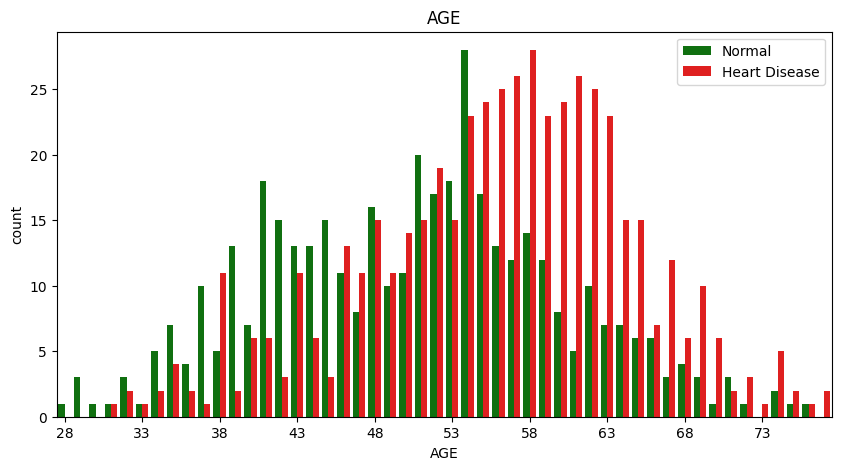

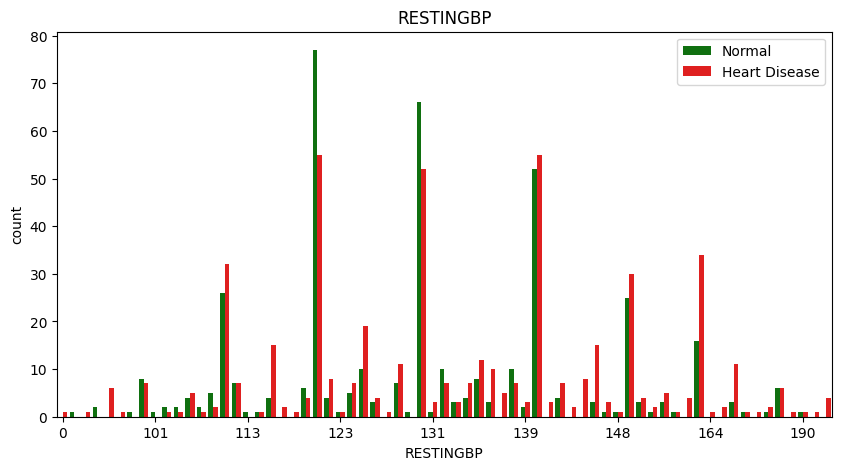

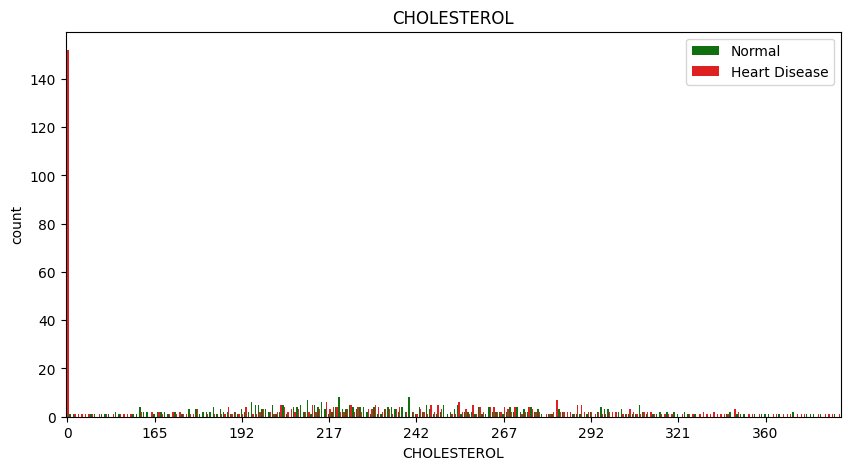

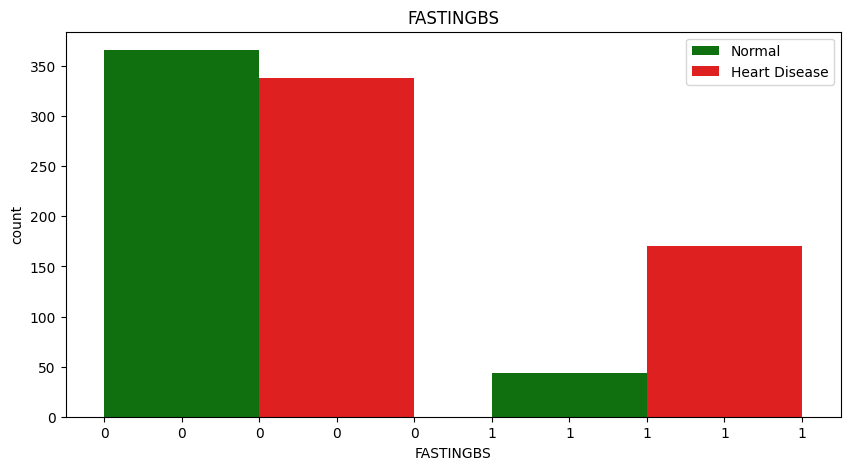

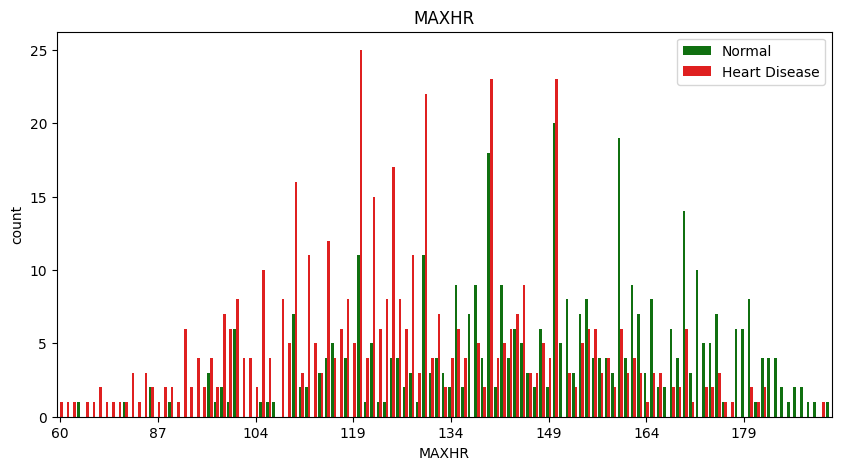

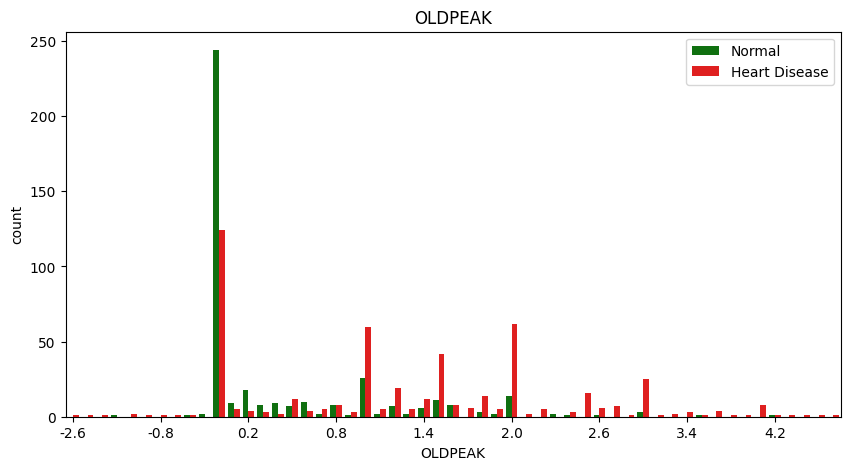

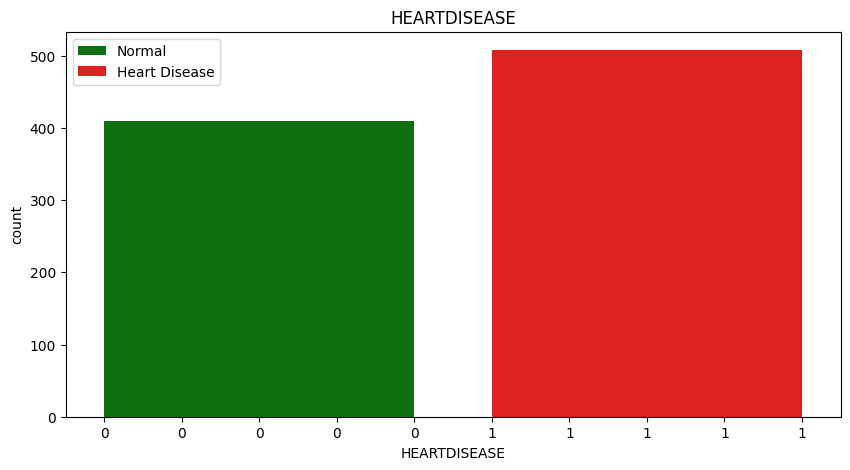

In [ ]:
from matplotlib.ticker import MaxNLocator

numerical_col = df.select_dtypes(include=['int64', 'float64'])
for i in numerical_col:
    plt.figure(figsize=(10,5))
    sns.countplot(x=i, data=df, hue='HEARTDISEASE', palette=['green', 'red'])  # Use a custom palette for different colors
    ax = plt.gca()  # Get current axis
    ax.xaxis.set_major_locator(MaxNLocator(nbins=10))  # Limit the number of x-axis ticks
    plt.legend(['Normal', 'Heart Disease'])
    plt.title(i)
    plt.show()
    print()

<ipython-input-13-e1968a325859>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['AGE'][df['HEARTDISEASE'] == 1], kde=True, color='red', label='Heart Disease')
<ipython-input-13-e1968a325859>:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['AGE'][df['HEARTDISEASE'] == 0], kde=True, color=

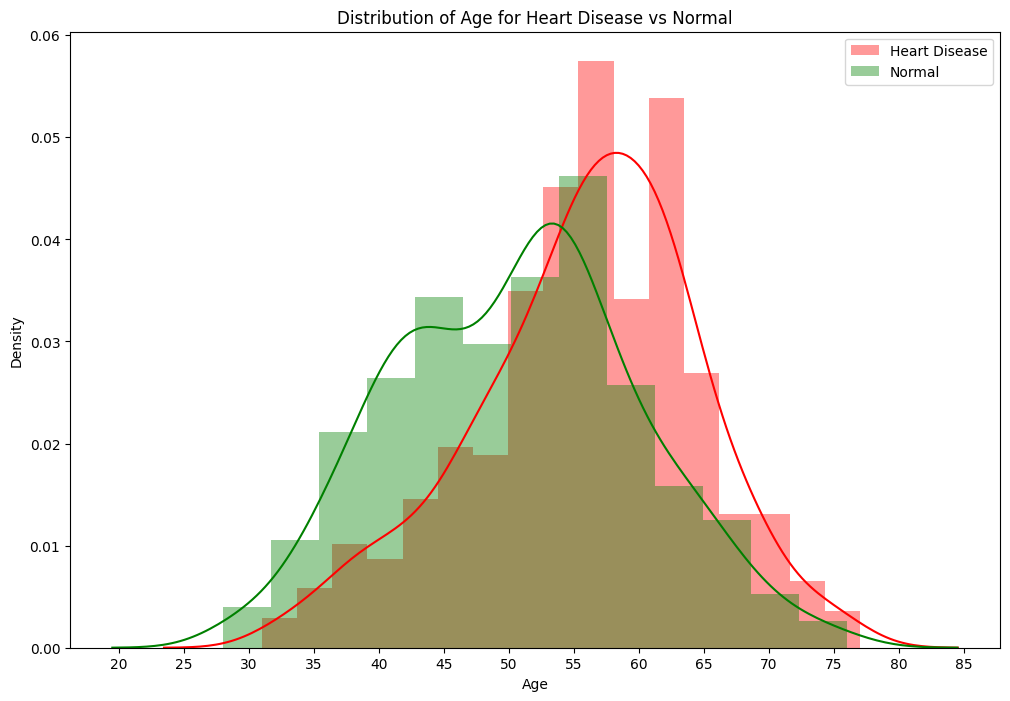

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Increase figure size
plt.figure(figsize=(12, 8))

# Distribution plot of Age for HeartDisease
sns.distplot(df['AGE'][df['HEARTDISEASE'] == 1], kde=True, color='red', label='Heart Disease')
sns.distplot(df['AGE'][df['HEARTDISEASE'] == 0], kde=True, color='green', label='Normal')

# Set x-axis tick frequency
plt.xticks(ticks=range(20, 90, 5))  # Add more ticks between 20 and 80 at intervals of 5

# Add labels and legend
plt.xlabel('Age')
plt.ylabel('Density')
plt.title('Distribution of Age for Heart Disease vs Normal')
plt.legend()

# Show the plot
plt.show()


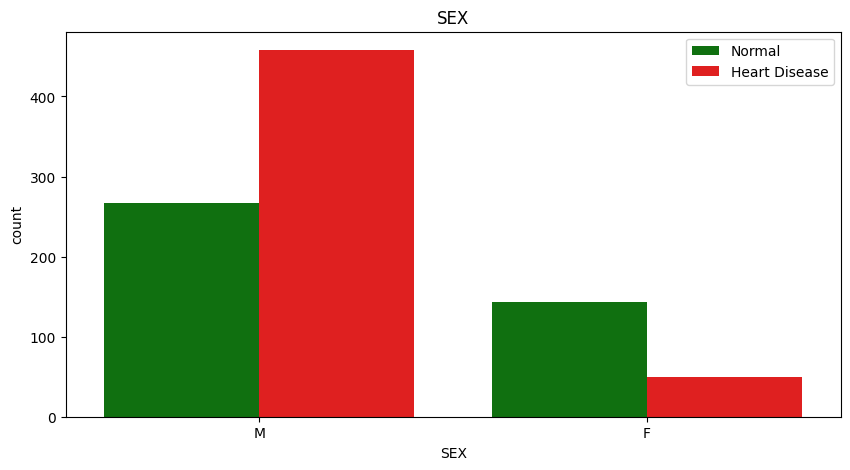

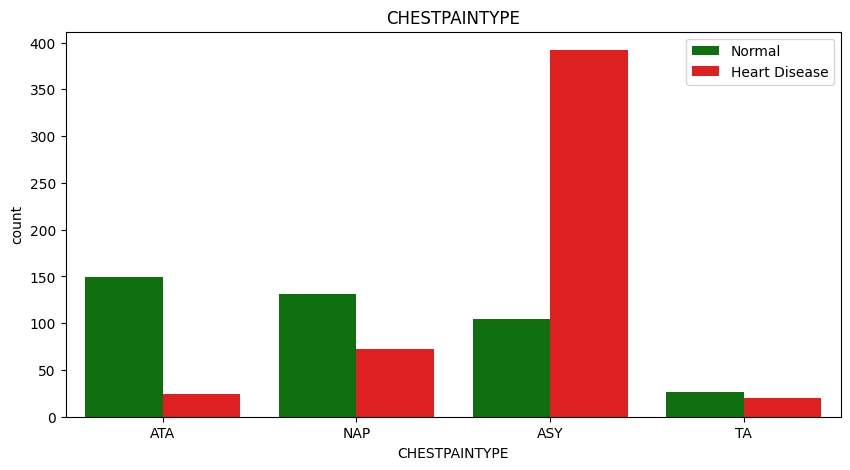

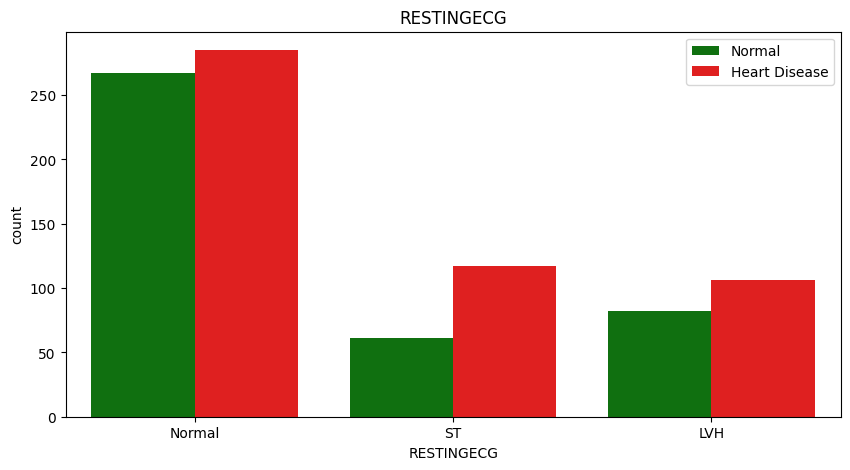

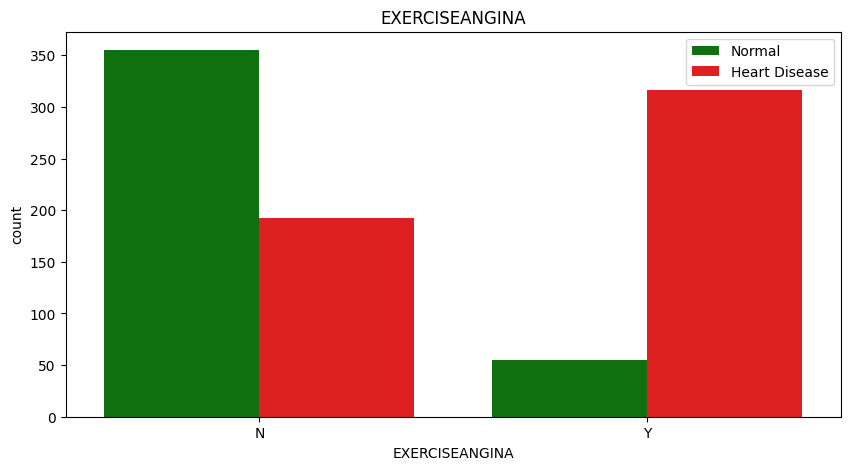

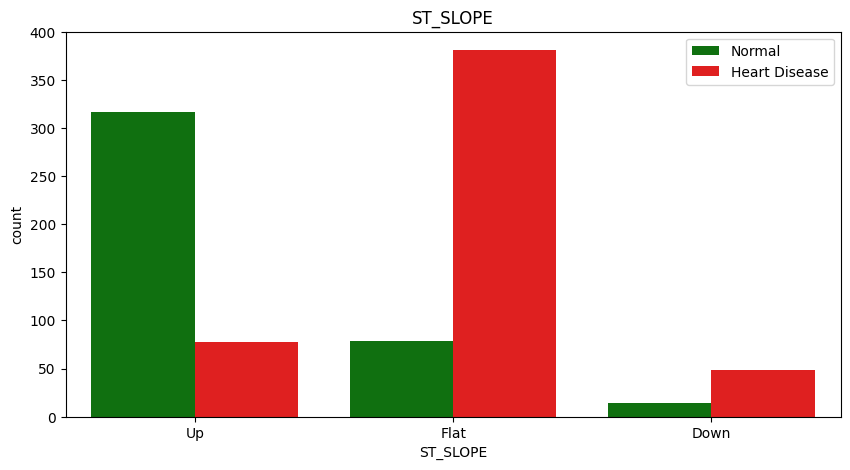

In [ ]:
from matplotlib.ticker import MaxNLocator
categ_col = ['SEX', 'CHESTPAINTYPE', 'RESTINGECG', 'EXERCISEANGINA', 'ST_SLOPE']

for i in categ_col:
    plt.figure(figsize=(10,5))
    sns.countplot(x=i, data=df, hue='HEARTDISEASE', palette=['green', 'red'])  # Use a custom palette for different colors
  # Limit the number of x-axis ticks
    plt.legend(['Normal', 'Heart Disease'])
    plt.title(i)
    plt.show()
    print()

# Data processing

In [ ]:
cat_cols, num_cols, cat_but_car, num_but_cat= grab_col_names(df)

print()

print(f"num_but_cat: {num_but_cat}")
print(f"cat_but_car: {cat_but_car}")
print(f"cat_cols: {cat_cols}")
print(f"num_cols: {num_cols}")

print()

missingvals = missing_values_table(df)
print(f"missing values: {missingvals}")

Total number of observations: 918
Total Variables: 12
No. of categorial columns: 7
No. of numerical columns: 5
No. of high-cardinality categorial columns: 0
No. of num. features with low no. of unique values treated as categorial: 2

num_but_cat: ['FASTINGBS', 'HEARTDISEASE']
cat_but_car: []
cat_cols: ['SEX', 'CHESTPAINTYPE', 'RESTINGECG', 'EXERCISEANGINA', 'ST_SLOPE', 'FASTINGBS', 'HEARTDISEASE']
num_cols: ['AGE', 'RESTINGBP', 'CHOLESTEROL', 'MAXHR', 'OLDPEAK']

Empty DataFrame
Columns: [n_miss, ratio]
Index: []
missing values: None


In [ ]:
(df==0).sum()

,0
AGE,0
SEX,0
CHESTPAINTYPE,0
RESTINGBP,1
CHOLESTEROL,172
FASTINGBS,704
RESTINGECG,0
MAXHR,0
EXERCISEANGINA,0
OLDPEAK,368


In [ ]:
 df[['AGE', 'CHESTPAINTYPE', 'RESTINGBP', 'CHOLESTEROL', 'MAXHR']] = df[['AGE', 'CHESTPAINTYPE', 'RESTINGBP', 'CHOLESTEROL', 'MAXHR']].replace(0, np.NaN)

## Nominal encoding

### Resting ECG

In [ ]:
from sklearn.preprocessing import OneHotEncoder

#Assuming chest pain is initially nominal data. so using hot encoding.
ohe_ecg = OneHotEncoder(handle_unknown='ignore', sparse_output=False).set_output(transform='pandas')

df_copy = pd.DataFrame()

if 'RESTINGECG' in df.columns:
    df_copy = df.copy()
    ohetransform_ecg = ohe_ecg.fit_transform(df_copy[['RESTINGECG']])
    df_copy = pd.concat([df_copy, ohetransform_ecg], axis=1).drop(columns=['RESTINGECG'])

    columns_to_reorder = ['RESTINGECG_LVH', 'RESTINGECG_Normal', 'RESTINGECG_ST']

    # Specify the position to insert these columns (e.g., starting from position 1)
    insert_position = 6

    # Iterate through the list of columns and pop them from the DataFrame
    for i, column in enumerate(columns_to_reorder):
        column_data = df_copy.pop(column)  # Pop the column from the DataFrame
        df_copy.insert(insert_position + i, column, column_data)  # Insert at the desired position

df_copy.head()

,AGE,SEX,CHESTPAINTYPE,RESTINGBP,CHOLESTEROL,FASTINGBS,RESTINGECG_LVH,RESTINGECG_Normal,RESTINGECG_ST,MAXHR,EXERCISEANGINA,OLDPEAK,ST_SLOPE,HEARTDISEASE
0,40,M,ATA,140.000,289.000,0,0.000,1.000,0.000,172,N,0.000,Up,0
1,49,F,NAP,160.000,180.000,0,0.000,1.000,0.000,156,N,1.000,Flat,1
2,37,M,ATA,130.000,283.000,0,0.000,0.000,1.000,98,N,0.000,Up,0
3,48,F,ASY,138.000,214.000,0,0.000,1.000,0.000,108,Y,1.500,Flat,1
4,54,M,NAP,150.000,195.000,0,0.000,1.000,0.000,122,N,0.000,Up,0


### Gender(dummy encoding)

In [ ]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first').set_output(transform='pandas')

df_copy1 = pd.DataFrame()       # Initialize df_copy1 to an empty DataFrame to avoid NameError if 'SEX' not in df_.columns

if 'SEX' in df_copy.columns:
    df_copy1 = df_copy.copy()
    ohetransform = ohe.fit_transform(df_copy1[['SEX']])
    df_copy1 = pd.concat([df_copy1, ohetransform], axis=1).drop(columns=['SEX'])              #.drop(columns=['SEX']) drops the initial sex column.
    sex_m_column = df_copy1.pop('SEX_M')
    df_copy1.insert(1, 'SEX', sex_m_column)

df_copy1.head()

,AGE,SEX,CHESTPAINTYPE,RESTINGBP,CHOLESTEROL,FASTINGBS,RESTINGECG_LVH,RESTINGECG_Normal,RESTINGECG_ST,MAXHR,EXERCISEANGINA,OLDPEAK,ST_SLOPE,HEARTDISEASE
0,40,1.000,ATA,140.000,289.000,0,0.000,1.000,0.000,172,N,0.000,Up,0
1,49,0.000,NAP,160.000,180.000,0,0.000,1.000,0.000,156,N,1.000,Flat,1
2,37,1.000,ATA,130.000,283.000,0,0.000,0.000,1.000,98,N,0.000,Up,0
3,48,0.000,ASY,138.000,214.000,0,0.000,1.000,0.000,108,Y,1.500,Flat,1
4,54,1.000,NAP,150.000,195.000,0,0.000,1.000,0.000,122,N,0.000,Up,0


### Exercise Angina(dummy encoding)

In [ ]:
ohe_exerciseangina = OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first').set_output(transform='pandas')

df_copy2 = pd.DataFrame()

if 'EXERCISEANGINA' in df_copy1.columns:
    df_copy2 = df_copy1.copy()
    ohetransform_exerciseangina = ohe_exerciseangina.fit_transform(df_copy1[['EXERCISEANGINA']])
    df_copy2 = pd.concat([df_copy2, ohetransform_exerciseangina], axis=1).drop(columns=['EXERCISEANGINA'])

    exang_col = df_copy2.pop('EXERCISEANGINA_Y')
    df_copy2.insert(10, 'EXERCISEANGINA', exang_col)

df_copy2.head()

,AGE,SEX,CHESTPAINTYPE,RESTINGBP,CHOLESTEROL,FASTINGBS,RESTINGECG_LVH,RESTINGECG_Normal,RESTINGECG_ST,MAXHR,EXERCISEANGINA,OLDPEAK,ST_SLOPE,HEARTDISEASE
0,40,1.000,ATA,140.000,289.000,0,0.000,1.000,0.000,172,0.000,0.000,Up,0
1,49,0.000,NAP,160.000,180.000,0,0.000,1.000,0.000,156,0.000,1.000,Flat,1
2,37,1.000,ATA,130.000,283.000,0,0.000,0.000,1.000,98,0.000,0.000,Up,0
3,48,0.000,ASY,138.000,214.000,0,0.000,1.000,0.000,108,1.000,1.500,Flat,1
4,54,1.000,NAP,150.000,195.000,0,0.000,1.000,0.000,122,0.000,0.000,Up,0


# Ordinal Encoding

ST Slope

In [ ]:
from sklearn.preprocessing import OrdinalEncoder

categories = ['Up', 'Flat', 'Down']
encoder = OrdinalEncoder(categories=[categories])
df_copy3 = df_copy2.copy()
df_copy3['ST_SLOPE'] = encoder.fit_transform(df_copy3[['ST_SLOPE']])

df_encoded = df_copy3.copy

df_copy3.head()

,AGE,SEX,CHESTPAINTYPE,RESTINGBP,CHOLESTEROL,FASTINGBS,RESTINGECG_LVH,RESTINGECG_Normal,RESTINGECG_ST,MAXHR,EXERCISEANGINA,OLDPEAK,ST_SLOPE,HEARTDISEASE
0,40,1.000,ATA,140.000,289.000,0,0.000,1.000,0.000,172,0.000,0.000,0.000,0
1,49,0.000,NAP,160.000,180.000,0,0.000,1.000,0.000,156,0.000,1.000,1.000,1
2,37,1.000,ATA,130.000,283.000,0,0.000,0.000,1.000,98,0.000,0.000,0.000,0
3,48,0.000,ASY,138.000,214.000,0,0.000,1.000,0.000,108,1.000,1.500,1.000,1
4,54,1.000,NAP,150.000,195.000,0,0.000,1.000,0.000,122,0.000,0.000,0.000,0


### Chest Pain

In [ ]:
categories_cp = ['ATA', 'NAP', 'TA', 'ASY']
encoder = OrdinalEncoder(categories=[categories_cp])
df_copy4 = df_copy3.copy()
df_copy4['CHESTPAINTYPE'] = encoder.fit_transform(df_copy4[['CHESTPAINTYPE']])

df_encoded = df_copy4.copy
df_copy4.head()

,AGE,SEX,CHESTPAINTYPE,RESTINGBP,CHOLESTEROL,FASTINGBS,RESTINGECG_LVH,RESTINGECG_Normal,RESTINGECG_ST,MAXHR,EXERCISEANGINA,OLDPEAK,ST_SLOPE,HEARTDISEASE
0,40,1.000,0.000,140.000,289.000,0,0.000,1.000,0.000,172,0.000,0.000,0.000,0
1,49,0.000,1.000,160.000,180.000,0,0.000,1.000,0.000,156,0.000,1.000,1.000,1
2,37,1.000,0.000,130.000,283.000,0,0.000,0.000,1.000,98,0.000,0.000,0.000,0
3,48,0.000,3.000,138.000,214.000,0,0.000,1.000,0.000,108,1.000,1.500,1.000,1
4,54,1.000,1.000,150.000,195.000,0,0.000,1.000,0.000,122,0.000,0.000,0.000,0


In [ ]:
columns = df_copy4.columns
columns = columns.drop('HEARTDISEASE')

for col in columns:
    df_copy4.loc[(df_copy4['HEARTDISEASE'] == 0) & (df_copy4[col].isna()),col] = df_copy4[df_copy4['HEARTDISEASE'] == 0][col].median()

    df_copy4.loc[(df_copy4['HEARTDISEASE'] == 1) & (df_copy4[col].isna()),col] = df_copy4[df_copy4['HEARTDISEASE'] == 1][col].median()


In [ ]:
#Standardising the data for ['AGE', 'RESTINGBP', 'CHOLESTEROL', 'MAXHR', 'OLDPEAK']
rs = StandardScaler()
df_copy4[num_cols] = rs.fit_transform(df_copy4[num_cols])

df_copy4.head()


,AGE,SEX,CHESTPAINTYPE,RESTINGBP,CHOLESTEROL,FASTINGBS,RESTINGECG_LVH,RESTINGECG_Normal,RESTINGECG_ST,MAXHR,EXERCISEANGINA,OLDPEAK,ST_SLOPE,HEARTDISEASE
0,-1.433,1.000,0.000,0.415,0.833,0,0.000,1.000,0.000,1.383,0.000,-0.832,0.000,0
1,-0.478,0.000,1.000,1.527,-1.211,0,0.000,1.000,0.000,0.754,0.000,0.106,1.000,1
2,-1.751,1.000,0.000,-0.141,0.721,0,0.000,0.000,1.000,-1.525,0.000,-0.832,0.000,0
3,-0.585,0.000,3.000,0.304,-0.573,0,0.000,1.000,0.000,-1.132,1.000,0.575,1.000,1
4,0.052,1.000,1.000,0.971,-0.930,0,0.000,1.000,0.000,-0.582,0.000,-0.832,0.000,0


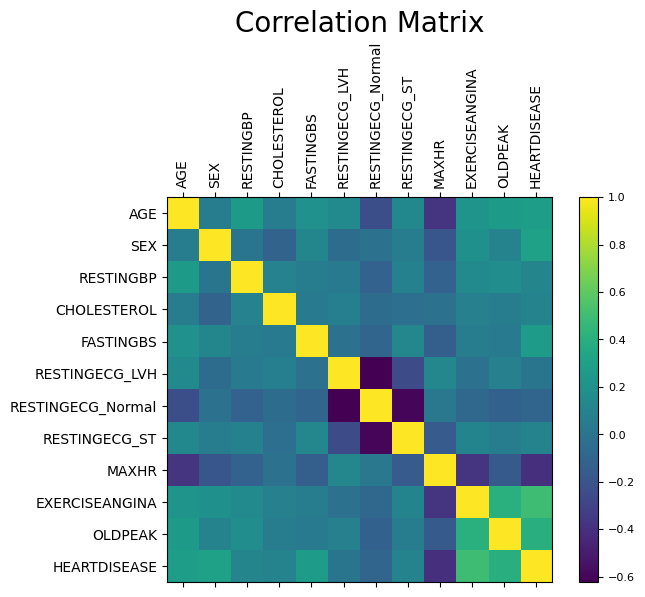

In [ ]:
f, ax = plt.subplots(figsize=[7, 5])
# Plot the correlation matrix using ax.matshow()
numeric_df = df_copy2.select_dtypes(include=np.number)
cax = ax.matshow(numeric_df.corr(), cmap='viridis')

# Set the x and y ticks for the correlation matrix
ax.set_xticks(range(df_copy2.select_dtypes(['number']).shape[1]))
ax.set_yticks(range(df_copy2.select_dtypes(['number']).shape[1]))
ax.set_xticklabels(df_copy2.select_dtypes(['number']).columns, fontsize=10, rotation=90)
ax.set_yticklabels(df_copy2.select_dtypes(['number']).columns, fontsize=10)
cb = f.colorbar(cax)
cb.ax.tick_params(labelsize=8)

ax.set_title("Correlation Matrix", fontsize=20)
plt.show()


### Model Training

In [ ]:
#l2 default logistic regression.

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

X = df_copy4.drop('HEARTDISEASE', axis=1)
y = df_copy4['HEARTDISEASE']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [ ]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
import numpy as np
from sklearn.metrics import classification_report


param_grid = {
    'C': [0.01, 0.1, 1, 10],             # Inverse of regularization strength
    'penalty': ['l1', 'l2'],                  # Regularization type
    'solver': ['liblinear', 'saga']           # Solver choice (saga is used for 'l1' and 'l2')
}

# Create an instance of the XGBClassifier
model_lgr = LogisticRegression(max_iter=1000,random_state=42)

# Create GridSearchCV instance
grid_search = GridSearchCV(estimator=model_lgr,
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=5, # 5-fold cross-validation
                           verbose=1,
                           n_jobs=-1)


grid_search.fit(X_train, y_train)

# Best parameters from grid search
print("Best parameters found: ", grid_search.best_params_)

# Using the best estimator to make predictions on the test set
best_model_lr = grid_search.best_estimator_
y_test_pred_lr = best_model_lr.predict(X_test)



# Evaluating the model
accuracy_lr = accuracy_score(y_test, y_test_pred_lr)
print(f"Test Accuracy: {accuracy_lr:.2f}")
print("Classification Report:\n", classification_report(y_test, y_test_pred_lr))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred_lr))



Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters found:  {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
Test Accuracy: 0.85
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.87      0.83        77
           1       0.90      0.84      0.87       107

    accuracy                           0.85       184
   macro avg       0.85      0.86      0.85       184
weighted avg       0.86      0.85      0.85       184

Confusion Matrix:
 [[67 10]
 [17 90]]


In [ ]:
# Feature importance for xgboost.
feat_importances = pd.Series(best_model_lr.coef_[0], index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.xlabel('Relative Importance')
plt.ylabel('Features')
plt.title('Feature Importances')
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

model_rf = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(estimator=model_rf,
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=5,  # 5-fold cross-validation
                           verbose=2,
                           n_jobs=-1)

grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_search.best_params_)
best_model_rfc = grid_search.best_estimator_

y_test_pred_rfc = best_model_rfc.predict(X_test)
accuracy_rfc = accuracy_score(y_test, y_test_pred_rfc)
print(f"Test Accuracy: {accuracy_rfc:.2f}")
print("Classification Report:\n", classification_report(y_test, y_test_pred_rfc))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred_rfc))

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters found:  {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
Test Accuracy: 0.89
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.86      0.86        77
           1       0.90      0.91      0.90       107

    accuracy                           0.89       184
   macro avg       0.88      0.88      0.88       184
weighted avg       0.89      0.89      0.89       184

Confusion Matrix:
 [[66 11]
 [10 97]]


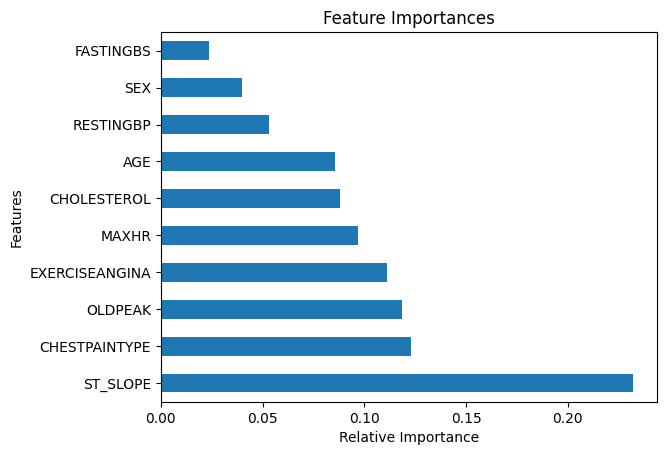

In [ ]:
# Feature importance for xgboost
feat_importances = pd.Series(best_model_rfc.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.xlabel('Relative Importance')
plt.ylabel('Features')
plt.title('Feature Importances')
plt.show()

Learn what is grid search, randomforest, xgboost.

In [ ]:
!pip install catboost # Install the catboost library

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 4.9 MB/s eta 0:00:00


In [ ]:
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Define the parameter grid for Grid Search
param_grid = {
    'iterations': [100, 200, 300],  # Number of boosting iterations
    'depth': [3, 4, 5],               # Depth of the trees
    'learning_rate': [0.01, 0.05, 0.1],  # Learning rate
    'l2_leaf_reg': [3, 5, 7],         # L2 regularization term
    'border_count':[32, 64, 128]        # Number of splits for numerical features
}

# Create an instance of the CatBoostClassifier
catboost_model = CatBoostClassifier(
    random_state=42,
    cat_features=[i for i, col in enumerate(X_train.columns) if X_train[col].dtype == 'object'],
    silent=True
)

# Create GridSearchCV instance
grid_search = GridSearchCV(estimator=catboost_model,
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=5,  # 5-fold cross-validation
                           verbose=1,
                           n_jobs=-1)

# Fit the model to the training data
grid_search.fit(X_train, y_train)

# Print the best parameters and the best score
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation accuracy: {:.2f}".format(grid_search.best_score_))

# Use the best model from grid search
best_model_cb = grid_search.best_estimator_

# Evaluate the best model on the test set
y_test_pred_cb = best_model_cb.predict(X_test)
accuracy_cb = accuracy_score(y_test, y_test_pred_cb)
print(f"Test Accuracy: {accuracy_cb:.5f}")
print("Classification Report:\n", classification_report(y_test, y_test_pred_cb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred_cb))

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters found:  {'border_count': 32, 'depth': 4, 'iterations': 300, 'l2_leaf_reg': 5, 'learning_rate': 0.05}
Best cross-validation accuracy: 0.89
Test Accuracy: 0.91304
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.90      0.90        77
           1       0.93      0.93      0.93       107

    accuracy                           0.91       184
   macro avg       0.91      0.91      0.91       184
weighted avg       0.91      0.91      0.91       184

Confusion Matrix:
 [[69  8]
 [ 8 99]]


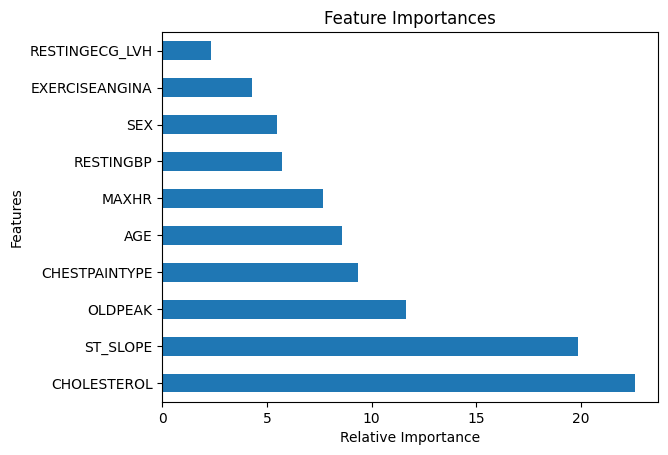

In [ ]:
# Feature importance for xgboost.
# Use best_model instead of xgb_model.
feat_importances = pd.Series(best_model_cb.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.xlabel('Relative Importance')
plt.ylabel('Features')
plt.title('Feature Importances')
plt.show()

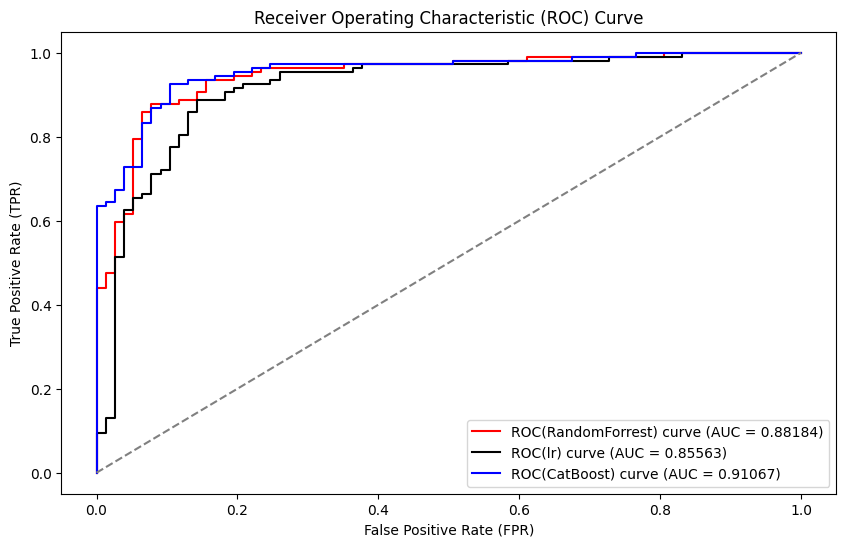

In [ ]:
import sklearn.metrics as metrics
from sklearn.metrics import roc_auc_score # Import roc_auc_score
## Calculate the fpr and tpr for all thresholds of the classification ##
## ... plot a roc curve ##
y_test_pred_proba_cb = best_model_cb.predict_proba(X_test)[:, 1]  # Probability for class 1
y_test_pred_proba_rfc = best_model_rfc.predict_proba(X_test)[:, 1]  # Probability for class 1
y_test_pred_proba_lr = best_model_lr.predict_proba(X_test)[:, 1]  # Probability for class 1

# y_test_pred_proba_cb = best_model_cb.predict_proba(X_test)[:, 1]  # Probability for class 1

fpr1, tpr1, thresholds1 = metrics.roc_curve(y_test, y_test_pred_proba_rfc)
fpr2, tpr2, thresholds2 = metrics.roc_curve(y_test, y_test_pred_proba_lr)
fpr3, tpr3, thresholds3 = metrics.roc_curve(y_test, y_test_pred_proba_cb)
#fpr3, tpr3, thresholds3 = metrics.roc_curve(y_test, y_test_pred_proba_rfc)

plt.figure(figsize=(10, 6))
plt.plot(fpr1, tpr1, color='r', label=f'ROC(RandomForrest) curve (AUC = {roc_auc_score(y_test, y_test_pred_rfc):.5f})') # Now you can use roc_auc_score
plt.plot(fpr2, tpr2, color='k', label=f'ROC(lr) curve (AUC = {roc_auc_score(y_test, y_test_pred_lr):.5f})') # Now you can use roc_auc_score
plt.plot(fpr3, tpr3, color='b', label=f'ROC(CatBoost) curve (AUC = {roc_auc_score(y_test, y_test_pred_cb):.5f})') # Now you can use roc_auc_score

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line for random guessing


plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

from sklearn.metrics import confusion_matrix
